In [2]:
# Import numerical packages
import numpy as np
import scipy as sp
from scipy import signal
from scipy import interpolate

# Import time packages
from datetime import datetime
from time import time

# Import databasing packages
import pandas as pd

# Import processing packages
from joblib import Parallel, delayed
from tqdm import tqdm

# Import Machine Learning packages
import seglearn as sgl
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tslearn.clustering import TimeSeriesKMeans
from fastdtw import fastdtw

# Import system packages
import os
import json

# Import plotting packages
import pylab as pl
import matplotlib
matplotlib.use('Agg')
%matplotlib notebook

# Data Evaluation
-------
## Quality & Integrity

First we'll load up the file, visualize the data, and begin answering some data integrity questions. Are there gaps in the data? Is the dataset sufficiently populated? 

In [3]:
p_data = pd.read_csv('../data/raw/pison_data_interview.csv', header=None)

In [4]:
# Quick view of the data to see what form it's in
p_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


In [5]:
# Rename the columns to their appropriate designations and display to confirm
p_data.rename(columns={0: 'timestamp',
                       1: 'c0',
                       2: 'c1',               
                       3: 'c0hp',
                       4: 'c1hp',
                       5: 'qx',
                       6: 'qy',
                       7: 'qz',
                       8: 'qw',
                       9: 'gx',
                       10: 'gy',
                       11: 'gz',
                       12: 'ax',
                       13: 'ay',
                       14: 'az',
                       15: 'label',
                       16: 'repnum'},
             inplace=True)
p_data.head()

,timestamp,c0,c1,c0hp,c1hp,qx,qy,qz,qw,gx,gy,gz,ax,ay,az,label,repnum
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


In [6]:
# Check for any null values in the dataset
p_data.isnull().sum()

timestamp    0
c0           0
c1           0
c0hp         0
c1hp         0
qx           0
qy           0
qz           0
qw           0
gx           0
gy           0
gz           0
ax           0
ay           0
az           0
label        0
repnum       0
dtype: int64

In [7]:
# Check for any duplicate entries in the dataset
p_data.duplicated().sum()

0

In [8]:
# Utilize Pandas' describe() function to get a better idea of the scope of each variable in the dataset
p_data.describe()

,timestamp,c0,c1,c0hp,c1hp,qx,qy,qz,qw,gx,gy,gz,ax,ay,az,label,repnum
count,1.498100e+04,1.498100e+04,1.498100e+04,14981.000000,1.498100e+04,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000,14981.000000
mean,1.566353e+06,1.253765e+07,1.251263e+07,62.550898,-2.571735e+02,0.263423,0.051271,0.111606,0.444427,6.407260,5.183960,2.237941,0.564972,-10.547218,2.064593,2.003071,1.991456
std,3.096750e+04,4.158465e+05,5.626673e+05,35397.290087,6.523863e+04,0.320534,0.395624,0.588643,0.335159,119.806613,346.986960,110.392775,7.242565,6.138921,6.852529,1.414352,0.815279
min,1.514825e+06,1.040201e+07,1.021268e+07,-422438.000000,-1.053204e+06,-0.897766,-0.777832,-1.000000,0.000000,-481.754550,-1830.891100,-623.763060,-34.382812,-48.960938,-27.765625,0.000000,1.000000
25%,1.538782e+06,1.245908e+07,1.233564e+07,-9221.000000,-1.041900e+04,0.032471,-0.085632,-0.304993,0.107849,-36.425343,-50.077854,-21.709728,-2.011719,-13.261719,-0.542969,1.000000,1.000000
50%,1.566517e+06,1.256078e+07,1.254805e+07,411.000000,3.980000e+02,0.230042,0.072815,0.036194,0.401611,-0.671435,-0.727388,1.678587,-0.363281,-9.816406,1.457031,2.000000,2.000000
75%,1.594422e+06,1.265877e+07,1.269320e+07,9792.000000,1.127500e+04,0.584961,0.329468,0.712097,0.754333,47.727833,50.413570,39.278942,3.582031,-7.398438,5.097656,3.000000,3.000000
max,1.618179e+06,1.419352e+07,1.504110e+07,640848.000000,1.726175e+06,0.905945,0.738708,1.000000,0.999268,427.312380,1828.317300,425.130220,37.671875,7.691406,33.898438,4.000000,3.000000


<IPython.core.display.Javascript object>


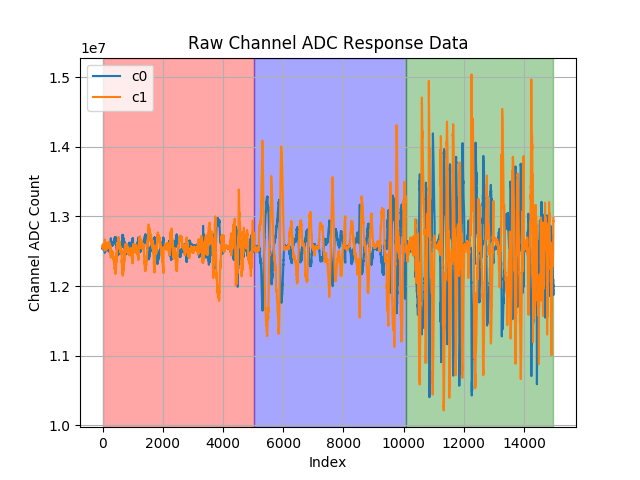

In [9]:
rep_idx = [p_data.loc[p_data.repnum==rI].iloc[-1].name for rI in [1, 2, 3]]
t_data = (p_data.timestamp - p_data.timestamp.min())/1000.
pl.figure()
pl.plot(p_data.c0)
pl.plot(p_data.c1)
pl.axvspan(0, rep_idx[0], color='red', alpha=0.35)
pl.axvspan(rep_idx[0]+1, rep_idx[1], color='blue', alpha=0.35)
pl.axvspan(rep_idx[1]+1, rep_idx[2], color='green', alpha=0.35)
pl.xlabel('Index')
pl.ylabel('Channel ADC Count')
pl.title('Raw Channel ADC Response Data')
pl.legend(['c0','c1'])
pl.grid()

In [9]:
# Check on the bit resolution of the channels
np.log(p_data[['c0','c1']].max()) / np.log(2)

c0    23.758730
c1    23.842407
dtype: float64

<IPython.core.display.Javascript object>


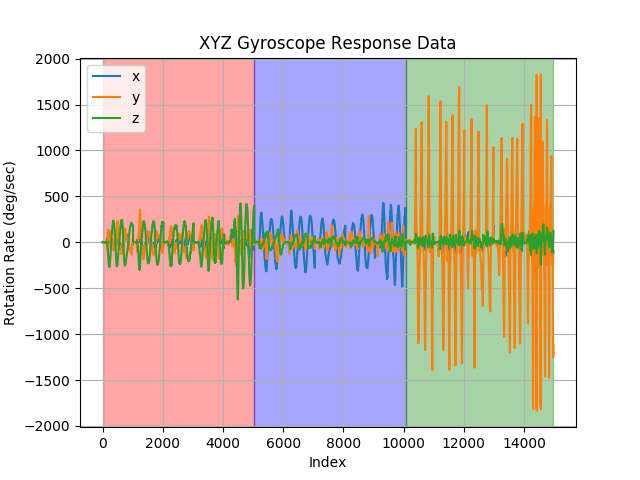

In [10]:
pl.figure()
pl.plot(p_data.gx)
pl.plot(p_data.gy)
pl.plot(p_data.gz)
pl.axvspan(0, rep_idx[0], color='red', alpha=0.35)
pl.axvspan(rep_idx[0]+1, rep_idx[1], color='blue', alpha=0.35)
pl.axvspan(rep_idx[1]+1, rep_idx[2], color='green', alpha=0.35)
pl.xlabel('Index')
pl.ylabel('Rotation Rate (deg/sec)')
pl.title('XYZ Gyroscope Response Data')
pl.legend(['x','y','z'])
pl.grid()

<IPython.core.display.Javascript object>


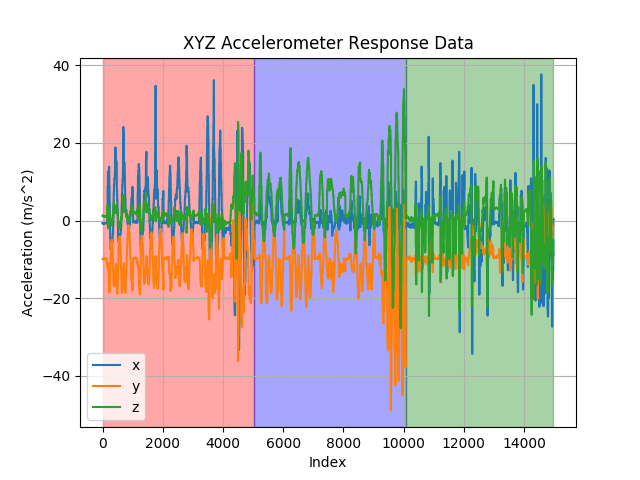

In [18]:
pl.figure()
pl.plot(p_data.ax)
pl.plot(p_data.ay)
pl.plot(p_data.az)
pl.axvspan(0, rep_idx[0], color='red', alpha=0.35)
pl.axvspan(rep_idx[0]+1, rep_idx[1], color='blue', alpha=0.35)
pl.axvspan(rep_idx[1]+1, rep_idx[2], color='green', alpha=0.35)
pl.xlabel('Index')
pl.ylabel('Acceleration (m/s^2)')
pl.title('XYZ Accelerometer Response Data')
pl.legend(['x','y','z'])
pl.grid()

As we can see, the data appears to be in good shape. There are no null values to worry about and no duplicate entries within the dataset. 

When viewing the data, it's clear that there are some very different responses recorded among the three repetition number periods. This is made evident in the plots above by the red background representing repetition one, blue for repetition two, and green for repetition three. As the two channels are registering the microvoltages running along the wrist that control both the wrist motion as well as finger movements, it appears that there is something significant happening during the last repetition.

This also appears to be the case with the gyroscope data. The third repetition appears to swing wildly in comparison to the previous two.

It looks like we have a different problem with the accelerometer readings. Judging by the response data, it looks like it has not been gravity compensated and, thus, contains contamination by the effects gravity is forcing on the device through the collection. In order to remove the gravity vector from the accelerometer readings, we will need to employ the quaternion to estimate the gravity vector and then subtract out that acceleration from the respective axes.

However, before we can use the quaternion, we need to ensure that it is in the same reference frame as the rest of the IMU sensors. To do this, we can rotate the quaternion from the West/South/Up frame to the ENU format of the accelerometer and gyroscope.

In [11]:
def gravity_compensate(data):
    """
    Function to utilize quaternion data to estimate the gravity vector and compensate the accelerometer readings for gravity
    
    :param data: Pandas Dataframe, dataframe containing all accelerometer and quaternion data
    
    :return accel_x: Series, x-axis gravity compensated accelerometer data
    :return accel_y: Series, y-axis gravity compensated accelerometer data
    :return accel_z: Series, z-axis gravity compensated accelerometer data
    :return grav_dir: Series, XYZ (3x1) estimated gravity vector
    """
    
    # Initialize output gravity vector
    g = [0.0, 0.0, 0.0]
    
    # get expected direction of gravity
    g[0] = 2 * ((-data.qx * data.qz) - (data.qw * -data.qy)) #q[1] * q[3] - q[0] * q[2])
    g[1] = 2 * ((data.qw * -data.qx) + (-data.qy * data.qz))#(q[0] * q[1] + q[2] * q[3])
    g[2] = data.qw**2 - data.qx**2 - data.qy**2 + data.qz**2
    
    # compensate accelerometer readings with the expected direction of gravity
    accel_x = (data.ax / 9.807) - g[0] 
    accel_y = (data.ay / 9.807) - g[1]
    accel_z = (data.az / 9.807) - g[2]
    grav_dir = g
    
    return accel_x, accel_y, accel_z, grav_dir

def quaternion_multiply(quaternion1, quaternion0):
    """
    Function to properly multiply quaternion rotations together
    
    :input quaternion1: array, N x 4 quaternion of the form w + xi + yj + zk
    :input quaternion2: array, N x 4 quaternion of the form w + xi + yj + zk
    
    :return output: array, N x 4 rotated quaternion of the form w + xi + yj + zk
    """
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [12]:
# Designate constants
g_const = 9.807

In [13]:
# Build out new earth-frame gravity compensated vectors
accel_x, accel_y, accel_z, grav_dir = gravity_compensate(p_data)

# Initialize gravity vector variables
p_data['grav_x'] = grav_dir[0]
p_data['grav_y'] = grav_dir[1]
p_data['grav_z'] = grav_dir[2]

# Initialize gravity compensated acceleration variables
p_data['ax_g'] = accel_x
p_data['ay_g'] = accel_y
p_data['az_g'] = accel_z

# Initialize gravity compensated acceleration magnitude
p_data['amag'] = np.sqrt(p_data.ax_g**2 + p_data.ay_g**2 + p_data.az_g**2)

<IPython.core.display.Javascript object>


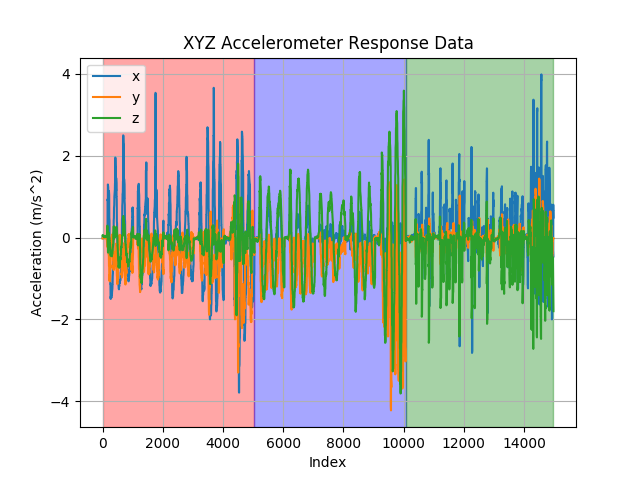

In [20]:
pl.figure()
pl.plot(p_data.ax_g)
pl.plot(p_data.ay_g)
pl.plot(p_data.az_g)
pl.axvspan(0, rep_idx[0], color='red', alpha=0.35)
pl.axvspan(rep_idx[0]+1, rep_idx[1], color='blue', alpha=0.35)
pl.axvspan(rep_idx[1]+1, rep_idx[2], color='green', alpha=0.35)
pl.xlabel('Index')
pl.ylabel('Acceleration (m/s^2)')
pl.title('XYZ Accelerometer Response Data')
pl.legend(['x','y','z'])
pl.grid()

By plotting the gravity compensated accelerometer data, we can confirm that the gravity estimation is working and we're looking at clean accelerometer readings.

# Data Insights, Feature Extraction, and Motion Detection
---------------

Now that the data evaluation and preprocessing is completed, we can begin to look into what the data is actually telling us. The easiest way to get a feel for the behaviors we're tasked with determining is to employ the gravity vector we just computed. This will give us an estimate of the orientation of the sensor as it is moved throughout the recording. If we can follow how the device moves, then we should be able to identify the type of wrist motion being performed by the subject in this experiment.

<IPython.core.display.Javascript object>


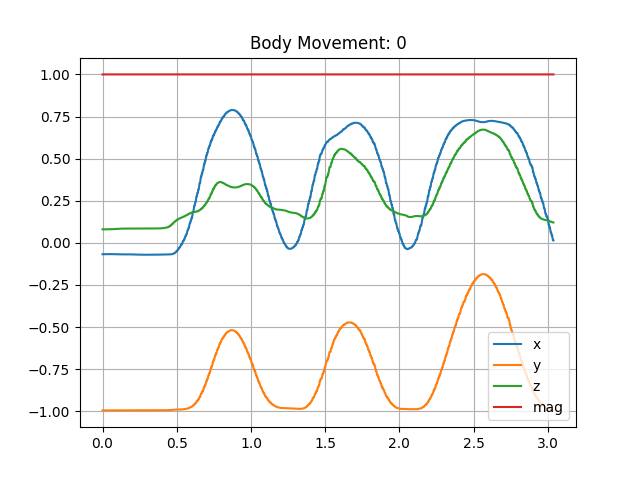

<IPython.core.display.Javascript object>


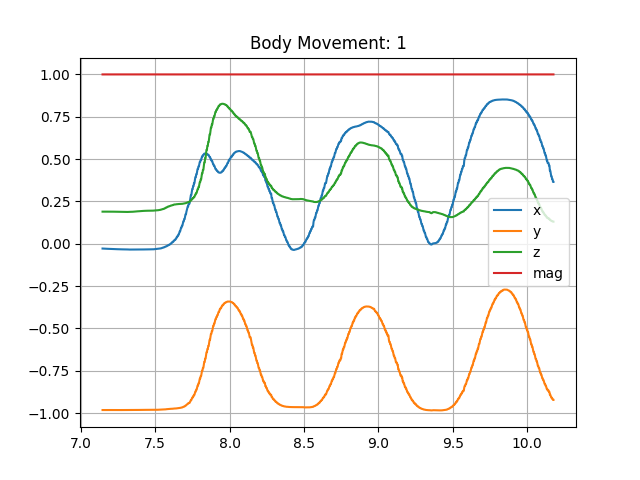

<IPython.core.display.Javascript object>


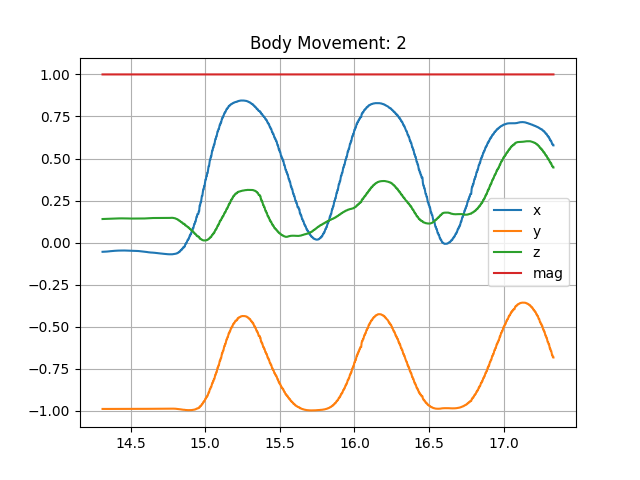

<IPython.core.display.Javascript object>


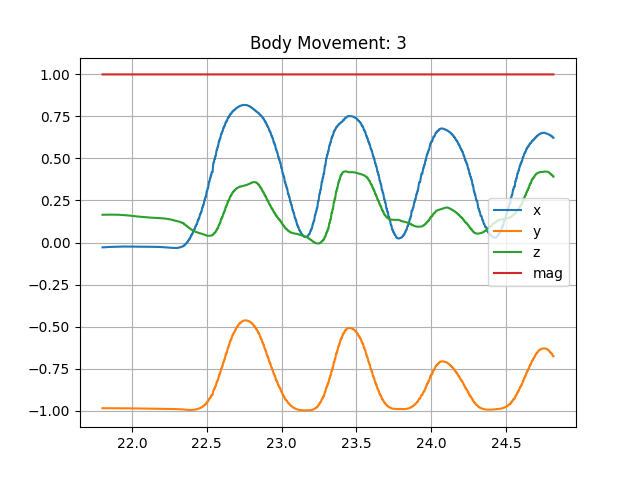

<IPython.core.display.Javascript object>


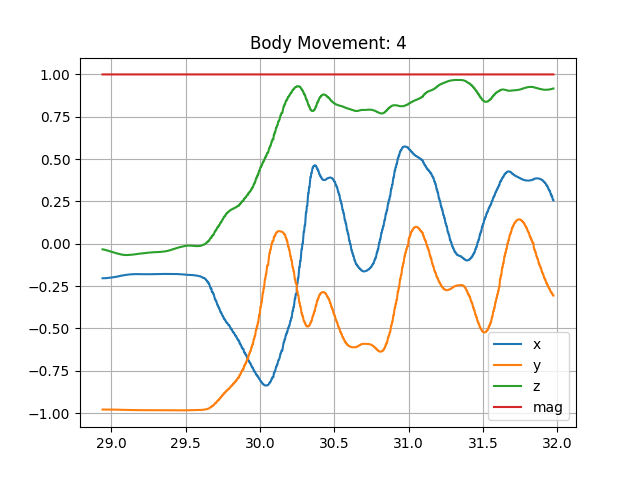

In [15]:
# Plot single body movement gravity vectors
repnum = 1
for iL in range(5):
    pl.figure()
    pl.title('Body Movement: {:}'.format(iL))
    t = (p_data.loc[(p_data.label==iL) & (p_data.repnum==repnum)].timestamp - p_data.timestamp.min())/1000.
    pl.plot(t,p_data.loc[(p_data.label==iL) & (p_data.repnum==repnum)].grav_x)
    pl.plot(t,p_data.loc[(p_data.label==iL) & (p_data.repnum==repnum)].grav_y)
    pl.plot(t,p_data.loc[(p_data.label==iL) & (p_data.repnum==repnum)].grav_z)
    pl.plot(t,np.sqrt(p_data.loc[(p_data.label==iL) & (p_data.repnum==repnum)].grav_x**2 +\
                    p_data.loc[(p_data.label==iL) & (p_data.repnum==repnum)].grav_y**2 +\
                    p_data.loc[(p_data.label==iL) & (p_data.repnum==repnum)].grav_z**2))
    # pl.plot(grav_dir[1])
    # pl.plot(grav_dir[2])
    # pl.plot(np.sqrt(grav_dir[0]**2 + grav_dir[1]**2 + grav_dir[2]**2))
    pl.grid()
    pl.legend(['x','y','z','mag'])

To fully understand what the gravity vector is telling us, first we must assume the orientation of the sensor. I am operating under the premise that the x-axis points positively out of the right side of the device. Thus, if the user is wearing the device on their right wrist, this would mean that the x-axis points positively up the arm. The y-axis then points positively out the top of the device perpendicular to the axis of the arm. And lastly, the z-axis points positively up and out of the device, or away from the outside of the arm.

Using this convention, we can now begin to parse the orientation of the device through the recorded session. To make things easier, we will use the first body movement as a template. This is because the first body movement relates to the subject standing still. With an inert subject, any signal response is from only the arm/wrist motion and not contaminated by the body's movement while walking or running.

With the stage set, it's possible to trace the orientation of the device through the motion. As we see from the above plot, there look to be several repeated motions or, at least, similar motions associated with the cyclical nature shown in the graph. At the beginning of the collection, the orientation of the device starts with the gravity vector pointing negatively, almost entirely, in the y-direction. This implies that the user is potentially holding their hand out in front of them with their palm facing to their left. The orientation then begins to shift from the y-axis more to the x-axis. As these two are perpendicular, this suggests the user is lowering their arm. However, the z-axis also begins to rise indicating that the user is rotating their wrist counter-clockwise as well. Thus, the overall motion appears to be a counter-clockwise rotation of the wrist while the user lowers their arm roughly half-way to their side.

An interesting conclusion from this is that we can likely gain an enormous amount of information about the wrist motion from the gyroscope sensor on the device. All **general** motion of the device within the user's frame of reference can be characterized through the rotational response recorded during each session. This includes arm motions (gait analysis while walking, arm raises/lowers, wrist rotations, etc.) Unfortunately, it lacks the ability to characterize specific behaviors associated with the fingers as the subtle motion likely wouldn't change the orientation of the device. This also pertains to the motion of bending or flexing the wrist. Although there may be slight responses registered on the gyroscope, it should show up in the microvoltage channels much more clearly since the microvoltages responsible for wrist bends likely to have much greater SNR in comparison to the gyroscope data. In the interest of brevity, I will focus my initial detection scheme on utilizing the gyroscope to gain a somewhat general attempt at motion detection. 

## Dynamic Time Warping
-----

Provided the time-series nature of our data and the unknown potential motions we are aiming to classify, I will be implementing a heuristic approach to motion detection. To handle this many unknowns, Dynamic Time Warping can be applied to the signal data. While a normal comparison between two signals would use a Euclidean distance measure to calculate a similarity/distance score, Dynamic Time Warping allows for the signal to attempt to stretch and compress the time axis to find the most likely matched data points between the signals. For example, if we compare two sine waves that are slightly out of phase from one another, the Euclidean distance metric would register a fairly large distance score. Meanwhile, the Dynamic Time Warping measure would be able to handle the slight time offset and deliver a much more accurate similarity score.

Unfortunately, there is very little data available in the supplied dataset. In an effort to increase our data supply, I will segment the data in overlapping windows and use these waveforms to perform the Dynamic Time Warping distance measure. Eyeballing the above plots for each repetition number show behavior that appears to have a period of roughly 0.5 seconds. Thus, that will be our window size and we will use a 50% overlap. Since we are not building a specific model for each waveform, we can utilize the entire dataset to locate matched signals and, thus, detect the specific motions registered during each repetition number and body movement.

In [16]:
def dtw_score(input_data):
    """
    Function to calculate the Dynamic Time Warping score between all of the signals within the associated body movement
    and repetition window
    
    :input input_data: Pandas Dataframe, dataframe containing all variable data for a specific body movement/repetition number
    
    :return pair_data: list, list containing the detected signal pairs and their distance score
    """
    #Initialize the output
    seg_class = []
    pair_data = []
    for i in range(len(input_data)):
        wind_class = []
        for j in range(len(input_data)):
            if (j==i):
                wind_class.append(np.inf)
                continue
                
            # Perform the dynamic time warping distance scoring
            wind_class.append(fastdtw(input_data[i].values, input_data[j].values)[0])
            
        # Accumulate scores over all passed signal windows
        seg_class.append(wind_class)
        
        # Construct output data
        pair_data.append([i,np.argmin(wind_class), min(wind_class)])
    return pair_data

def get_dtw_pair_data(pair_data):
    """
    Function to remove duplicate signal pairs to avoid double counting
    
    :input pair_data: list, list containing pairwise signal information
    
    :return matches: list, list containing the pared down signal matches
    """
    ind_rem = []
    matches = []
    for i in range(len(seg_data)):
        if np.isinf(pair_data[i][2]):
            continue
        elif i in ind_rem:
            continue
        elif i in [0, 1]:
            continue
        elif pair_data[pair_data[i][1]][1] == i:
            matches.append([i, pair_data[pair_data[i][1]][0], np.mean([pair_data[i][2], pair_data[pair_data[i][1]][2]])])
            ind_rem.append(pair_data[pair_data[i][1]][0])
            
    return matches

def segment_data(input_data, window=170, overlap=0.5, variable='gy'):
    """
    Function to automatically segment the available data into smaller/overlapping windows
    
    :input input_data: Pandas Dataframe, dataframe containing all variable information for specific scenarios
    :input window: int, window length
    :input overlap: float, fraction of window overlap (0.0 - 1.0) with 0.0 registering as no overlap
    :input variable: str, string indexer into dataframe columns
    
    :return seg_data: list, list of lists of the segmented data
    """
    start = np.arange(0, len(input_data), int(window*overlap))
    stop = np.arange(int(window*overlap), len(input_data)+int(window*overlap), int(window*overlap))
    seg_data = []
    inds = []
    for sI in range(len(start)):
        inds.append(np.arange(start[sI],min(start[sI]+window, len(input_data))))
        seg_data.append(input_data[variable].iloc[start[sI]:min(start[sI]+window, len(input_data))])
        if min(start[sI]+window, len(input_data)) == len(input_data):
               break          
    return seg_data

def seg_inds(input_data, window=170, overlap=0.5, variable='gy'):
    """
    Function to automatically segment the available data into smaller/overlapping windows and output the associated indices
    
    :input input_data: Pandas Dataframe, dataframe containing all variable information for specific scenarios
    :input window: int, window length
    :input overlap: float, fraction of window overlap (0.0 - 1.0) with 0.0 registering as no overlap
    :input variable: str, string indexer into dataframe columns
    
    :return inds: list, list of lists of the segmented data indices
    """
    start = np.arange(0, len(input_data), int(window*overlap))
    stop = np.arange(int(window*overlap), len(input_data)+int(window*overlap), int(window*overlap))
    seg_data = []
    inds = []
    for sI in range(len(start)):
        inds.append(np.arange(start[sI],min(start[sI]+window, len(input_data))))
        seg_data.append(input_data[variable].iloc[start[sI]:min(start[sI]+window, len(input_data))])
        if min(start[sI]+window, len(input_data)) == len(input_data):
               break          
    return inds

def plot_pairs(m_data, inds, b_move, repnum, all_data, window=200):
    """
    Function to easily plot the related matched signal data
    
    :input m_data: list, list of matched signal response data
    :input inds: list, list of matched signal indices
    :input b_move: int, label for body movement
    :input repnum: int, label for repetition number
    :input all_data: Pandas Dataframe, dataframe containing all gravity information for plotting purposes
    :input window: int, window length of the signals
    """
    inds = seg_inds(test_data, variable='gy')
    seg_data = segment_data(test_data, variable='gy')

    r_num = len(m_data)
    c_num = 1
    fig, ax = pl.subplots(nrows=r_num, ncols=c_num)
    if len(m_data) == 1:
        ax.set_title('Body Movement: {:}, Repetition Number: {:}'.format(b_move, repnum))
        ax.plot(inds[m_data[0][0]], all_data['grav_x'].iloc[inds[m_data[0][0]]],color='red')
        ax.plot(inds[m_data[0][0]], all_data['grav_y'].iloc[inds[m_data[0][0]]],color='blue')
        ax.plot(inds[m_data[0][0]], all_data['grav_z'].iloc[inds[m_data[0][0]]],color='green')
        ax.legend(['grav_x','grav_y','grav_z'])
        
        ax.plot(inds[m_data[0][1]]+window, all_data['grav_x'].iloc[inds[m_data[0][1]]],color='red',linestyle='--')
        ax.plot(inds[m_data[0][1]]+window, all_data['grav_y'].iloc[inds[m_data[0][1]]],color='blue',linestyle='--')
        ax.plot(inds[m_data[0][1]]+window, all_data['grav_z'].iloc[inds[m_data[0][1]]],color='green',linestyle='--')
        ax.grid(True)
    else:
        for row in range(r_num):
            for col in range(c_num):
                ax[row].plot(inds[m_data[row][0]], all_data['grav_x'].iloc[inds[m_data[row][0]]],color='red')
                ax[row].plot(inds[m_data[row][0]], all_data['grav_y'].iloc[inds[m_data[row][0]]],color='blue')
                ax[row].plot(inds[m_data[row][0]], all_data['grav_z'].iloc[inds[m_data[row][0]]],color='green')
                ax[row].legend(['grav_x','grav_y','grav_z'])
                
                ax[row].plot(inds[m_data[row][1]]+window, all_data['grav_x'].iloc[inds[m_data[row][1]]],color='red',linestyle='--')
                ax[row].plot(inds[m_data[row][1]]+window, all_data['grav_y'].iloc[inds[m_data[row][1]]],color='blue',linestyle='--')
                ax[row].plot(inds[m_data[row][1]]+window, all_data['grav_z'].iloc[inds[m_data[row][1]]],color='green',linestyle='--')
                ax[row].grid(True)
        ax[0].set_title('Body Movement: {:}, Repetition Number: {:}'.format(b_move, repnum))
    

<IPython.core.display.Javascript object>


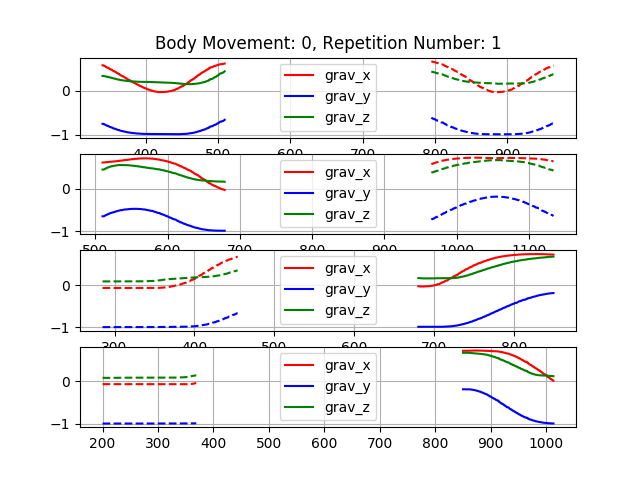

[[4, 7, 4589.033743260001], [6, 9, 3837.6982005999994], [8, 1, 4621.290644909999], [10, 0, 2856.7318776600027]]


<IPython.core.display.Javascript object>


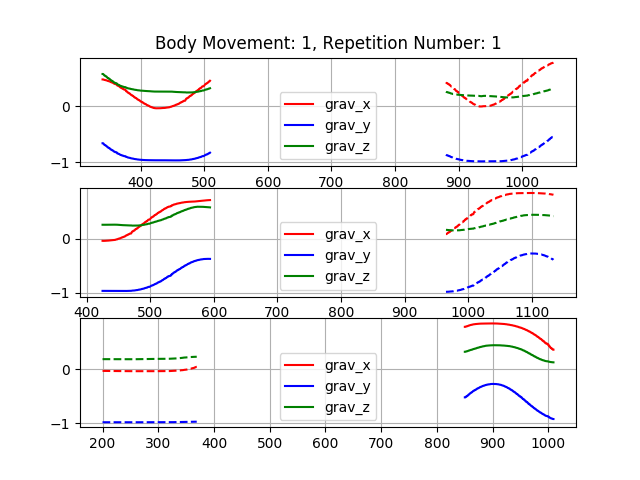

[[4, 8, 3669.895187400002], [5, 9, 2630.4582686199947], [10, 0, 3346.991180050002]]


<IPython.core.display.Javascript object>


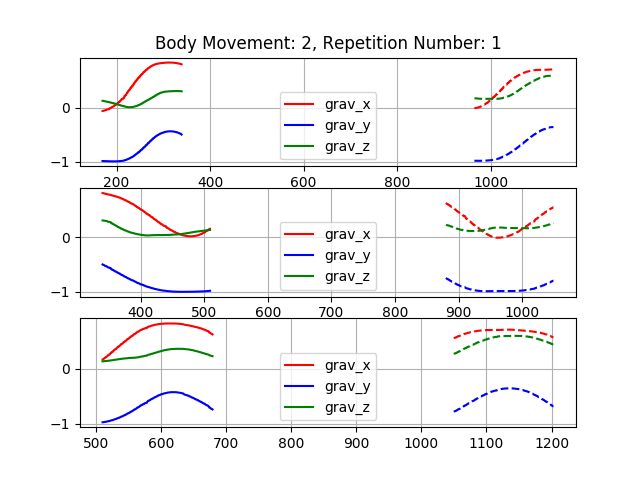

[[2, 9, 3588.9315788900008], [4, 8, 3680.6384458], [6, 10, 1921.1990390400003]]


<IPython.core.display.Javascript object>


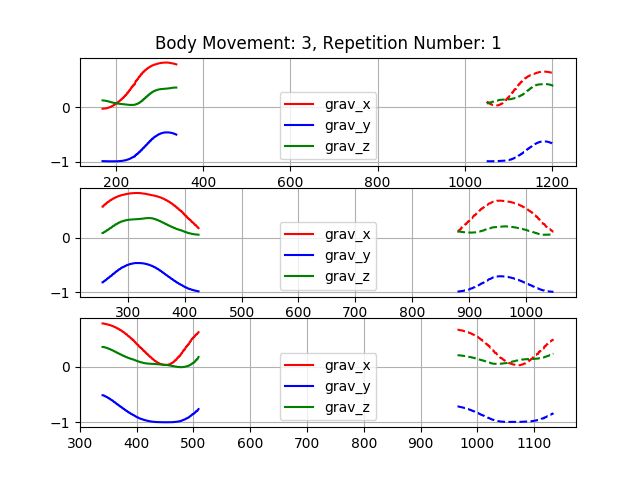

[[2, 10, 2676.227526049999], [3, 8, 4391.8277007], [4, 9, 3229.993719400001]]


<IPython.core.display.Javascript object>


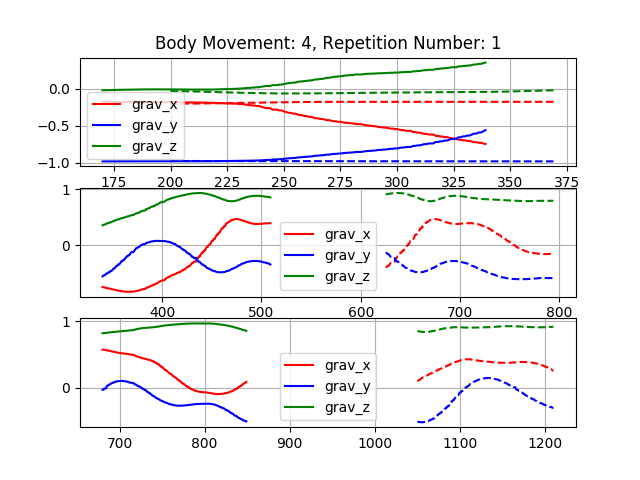

[[2, 0, 1936.3343617399996], [4, 5, 10969.11999719999], [8, 10, 1579.326759179999]]


<IPython.core.display.Javascript object>


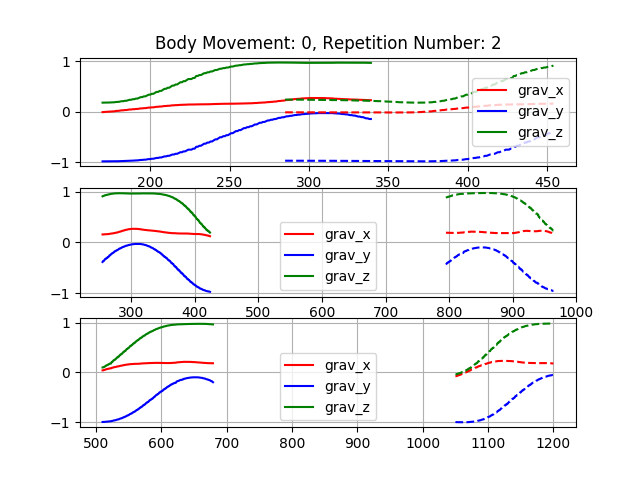

[[2, 1, 1974.634149569998], [3, 7, 2934.7301396499975], [6, 10, 1138.4179230999991]]


<IPython.core.display.Javascript object>


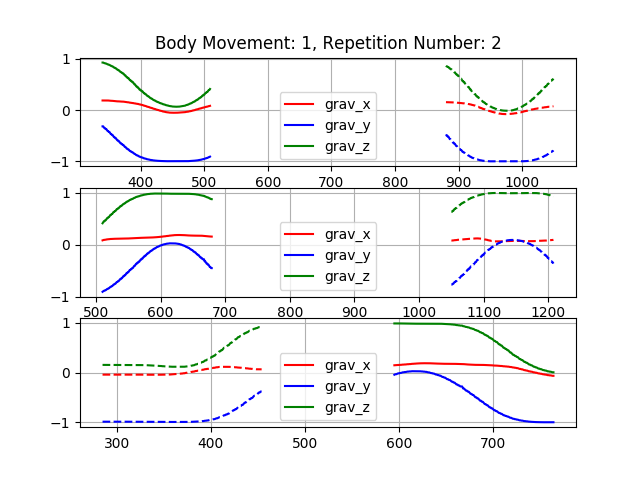

[[4, 8, 2190.9480327499996], [6, 10, 2607.4056095200003], [7, 1, 1631.5868285000001]]


<IPython.core.display.Javascript object>


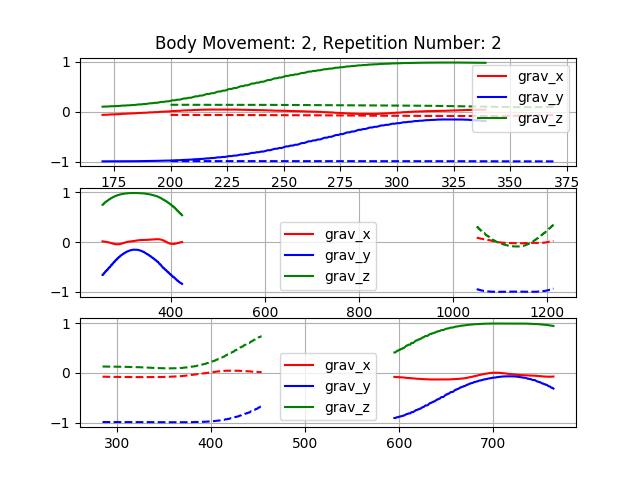

[[2, 0, 1354.34011314], [3, 10, 2580.436254659999], [7, 1, 2877.1825205999976]]


<IPython.core.display.Javascript object>


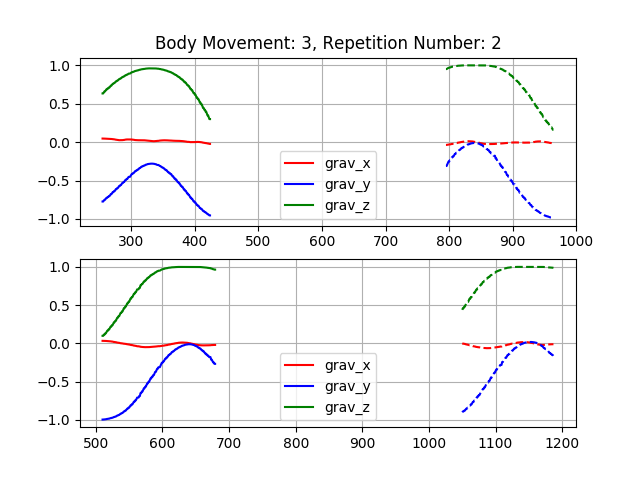

[[3, 7, 2616.7777093000004], [6, 10, 1372.3011051800013]]


<IPython.core.display.Javascript object>


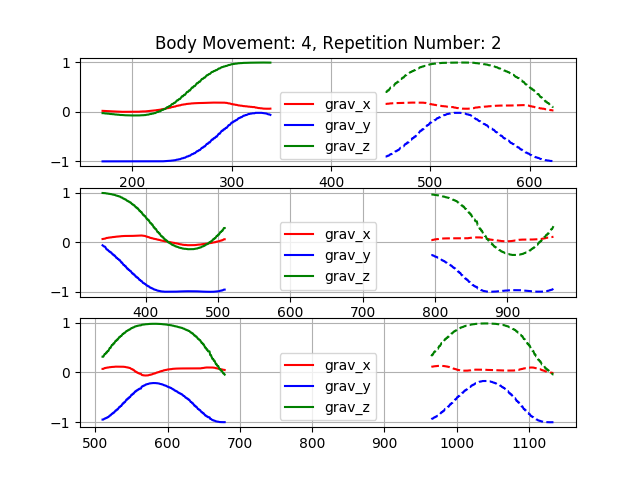

[[2, 3, 5044.602411599997], [4, 7, 3739.0531263000007], [6, 9, 3965.186980600003]]


<IPython.core.display.Javascript object>


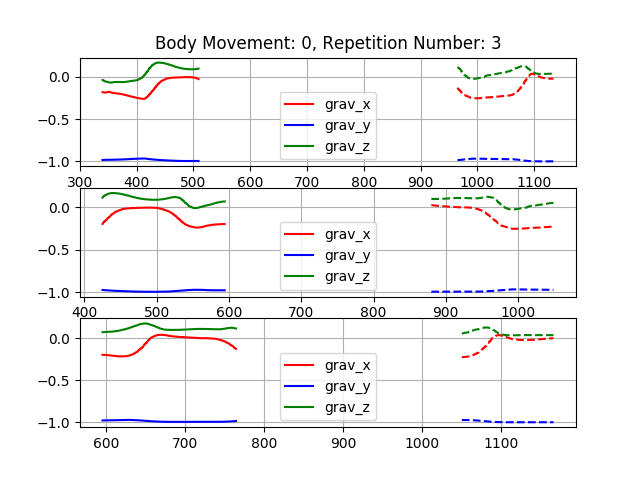

[[4, 9, 15220.758850360002], [5, 8, 25669.627024500023], [7, 10, 27279.50688668]]


<IPython.core.display.Javascript object>


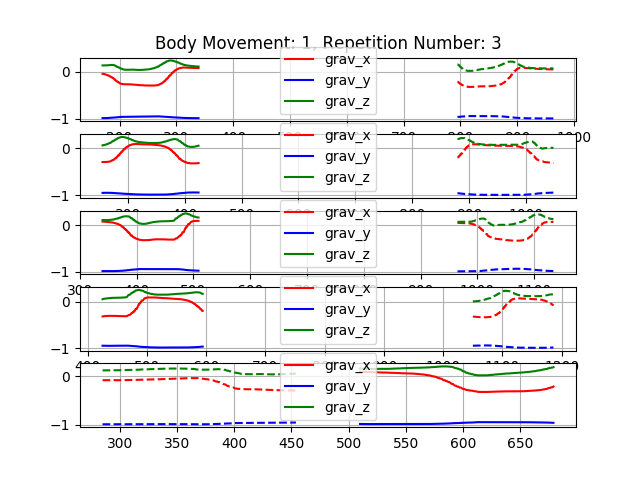

[[2, 7, 12063.78316186999], [3, 8, 19036.020299569976], [4, 9, 12934.635808999998], [5, 10, 5991.885782199998], [6, 1, 14065.443188759991]]


/home/zuggie/base_python3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


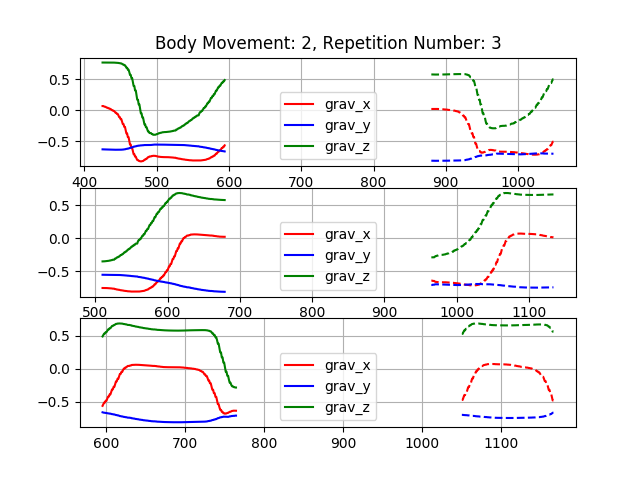

[[5, 8, 10347.875992799993], [6, 9, 3663.0134166], [7, 10, 13876.992307099998]]


<IPython.core.display.Javascript object>


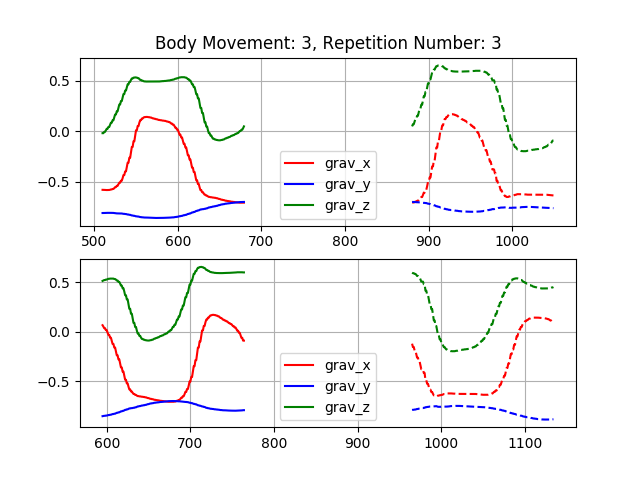

[[6, 8, 3728.0319287999996], [7, 9, 5319.5552260999975]]


<IPython.core.display.Javascript object>


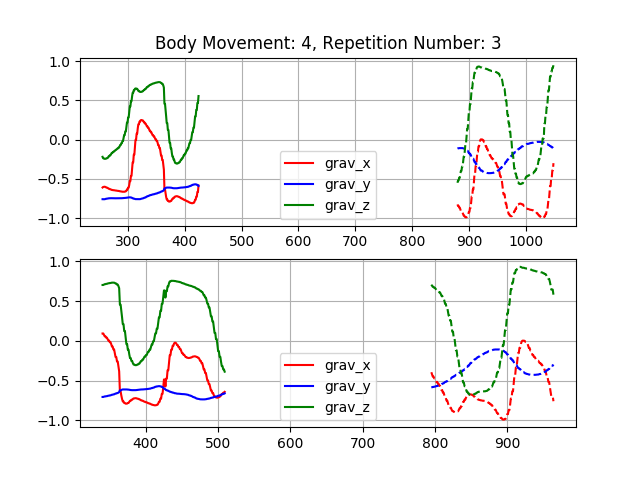

[[3, 8, 19289.26155620001], [4, 7, 21355.994634299983]]


In [17]:
# Process the segmented signal data to detect any specific wrist motions in the dataset
for rI in [1,2,3]:
    for lI in range(5):
        test_data = p_data.loc[(p_data.label==lI) & (p_data.repnum==rI)]
        seg_data = segment_data(test_data, window=170, overlap=0.5, variable='gy')
        dtw_data = dtw_score(seg_data)
        pair_data = get_dtw_pair_data(dtw_data)
        inds = seg_inds(test_data, window=70, overlap=0.5, variable='gy')
        plot_pairs(pair_data, inds, lI, rI, test_data)

        print(get_dtw_pair_data(dtw_score(segment_data(test_data, variable='gy'))))

Provided the above processing and the visualizations, we can see that there appear to be three distinct motions during the first repetition number. The first being lowering the arm to the subject's side from a position parallel to the floor. Then there is the reverse motion bringing the arm back up to the parallel. Lastly, we can characterize the remaining wrist motion as a rotation of approximately 45 degrees and back.

Within the second repetition number stage, there only appears to be rotational movement of the wrist. However, this time, the subject appears to complete nearly a full 90 degrees rotation from the palm facing left, to the palm facing down to the floor. Meanwhile, the arm's position mimics the initial setup from the first repetition; outstretched and parallel to the ground.

The third and last repetiton number looks to perform nearly the opposite behavior as the first repetition. One of the motions is raising the arm from the outstrected and parallel to the floor position. The second is the reverse action of bringing the arm back down to the parallel. And lastly, the third wrist motion is a rotation that mimics the rotational behavior from the first repetition.

It can be noted that reprocessing through the data utilizing the magnitude of the gravity compensated accelerometer response data yielded the same signal snippets as the gyroscope (with some small exceptions) within the total recording. As the behavior I was looking to detect was more rotational/orientation based, it makes sense that the gyroscope would produce higher fidelity results.

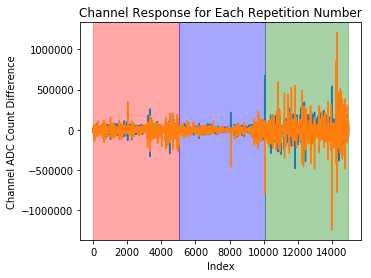

In [19]:
rep_idx = [p_data.loc[p_data.repnum==rI].iloc[-1].name for rI in [1, 2, 3]]
t_data = (p_data.timestamp - p_data.timestamp.min())/1000.
pl.figure()
pl.axvspan(0, rep_idx[0], color='red', alpha=0.35)
pl.axvspan(rep_idx[0]+1, rep_idx[1], color='blue', alpha=0.35)
pl.axvspan(rep_idx[1]+1, rep_idx[2], color='green', alpha=0.35)
pl.plot(p_data.c0.diff())
pl.plot(p_data.c1.diff())
pl.xlabel('Index')
pl.ylabel('Channel ADC Count Difference')
pl.title('Channel Response for Each Repetition Number')
pl.subplots_adjust(left=.25)

Although we have identified the separate motions recorded by the gyroscope (and verified with the accelerometer), we still haven't touched the microvoltage channel data. When viewing the above plot, it's clear that there is some serious nerve activity during the last repetition number stage. So despite having roughly classified the wrist motion, it looks like there is still a lot we're missing. However, without any further explanation of how the voltage data may respond to wrist bends and/or finger curls/extensions, it's unclear as to how this information can be used to further characterize the subject's behavior.

In [20]:
def get_pry(data):
    """
    Function to construct Euler angles from the gravity compensated accelerometer data
    
    :input data: Pandas Dataframe, dataframe contaning all gravity compensated accelerometer data
    
    :return pitch: Series, time-series data containing all pitch angles
    :return roll: Series, time-series data containing all roll angles
    :return yaw: Series, time-series data containing all yaw angles
    """
    pitch = 180. * np.arctan(data.ax_g / np.sqrt(data.ay_g**2 + data.az_g**2)) / np.pi
    roll = 180. * np.arctan(data.ay_g / np.sqrt(data.ax_g**2 + data.az_g**2)) / np.pi
    yaw = 180. * np.arctan(data.az_g / np.sqrt(data.ax_g**2 + data.az_g**2)) / np.pi
    
    return pitch, roll, yaw

def smooth(data, window):
    """
    Simple window smoothing function
    
    :input data: Series, time-series data
    :input window: int, window length
    
    :return data_smooth: Series, smoothed time-series data
    """
    window = np.ones(window)/window
    data_smooth = np.convolve(data, window, mode='same')
    return data_smooth

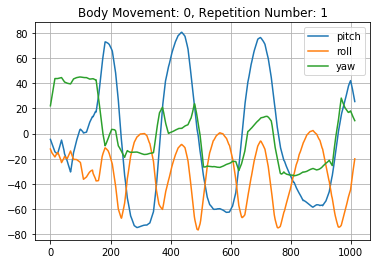

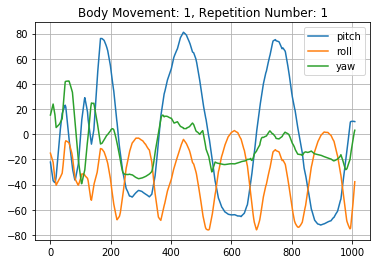

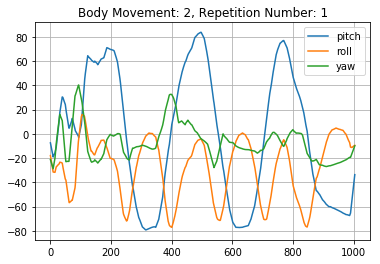

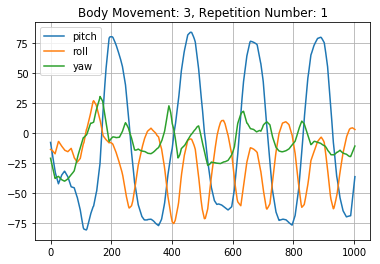

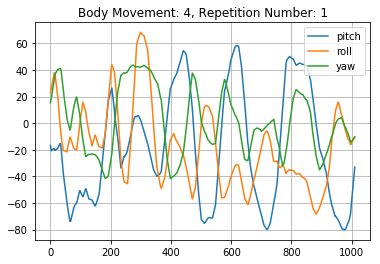

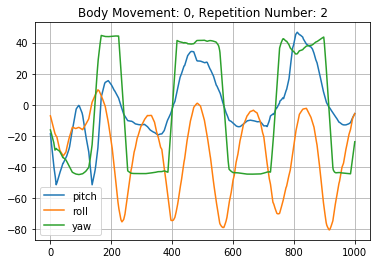

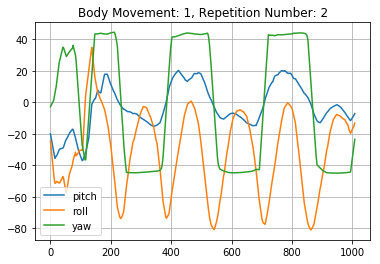

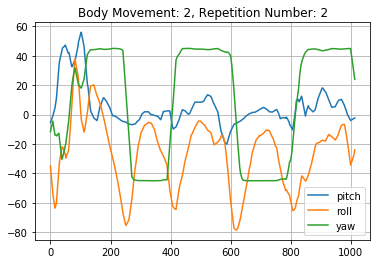

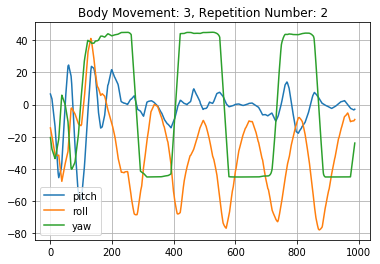

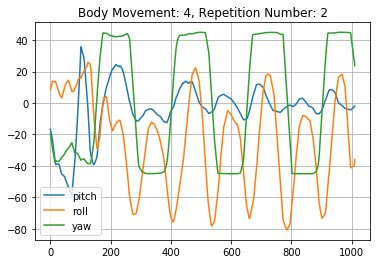

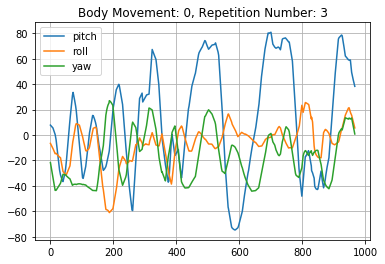

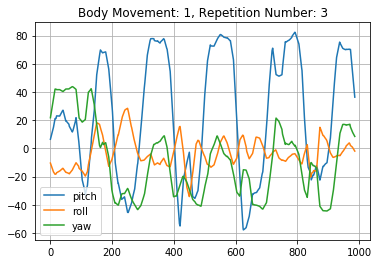

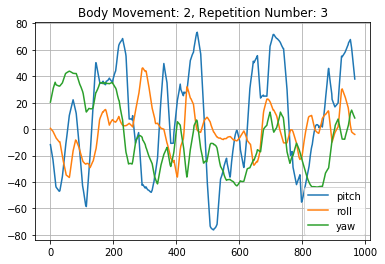

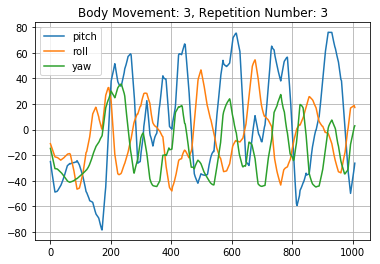

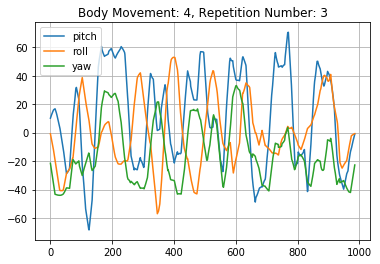

In [21]:
for rI in [1,2,3]:    
    for iL in range(5):
        pl.figure()
        pitch, roll, yaw = get_pry(p_data.loc[(p_data.label==iL) & (p_data.repnum==rI)])
        pl.plot(smooth(pitch, 30))
        pl.plot(smooth(roll, 30))
        pl.plot(smooth(yaw, 30))  
        pl.legend(['pitch','roll','yaw'], loc='best')
        pl.grid()
        pl.title('Body Movement: {:}, Repetition Number: {:}'.format(iL, rI))

In conjunction with the gravity vector data, we can utilize the Euler angles to confirm what we saw in each of the above wrist motions. By creating a heuristic detection and classification schema, we can employ all of the above to improve the accuracy and confidence of our classifications. Taking the first plot, as described above, we can confirm that the oscillatory pitching is related to the rotational motion of the wrist. Meanwhile, the roll related to the lowering and raising of the arm. And lastly, the yaw would indicate any side-to-side motion.

## Conclusion
--------

Although this is a fairly basic exploration into the data, we have still come out with some interesting findings. With the task of the project being to attempt to detect and classify wrist motion, the decision was made to restrict the scope of our investigation due to both the time constraints as well as the immense number of assumptions that needed to be made. This includes the ambiguity of what is happening during each body movement, what the repetition number actually describes, whether there are multiple different wrist motions during a repetition number, how the channels are oriented on the device, what is the actual orientation of the IMU sensor on the device, as well as which wrist the user is wearing the device on. Additionally, there is no prior explanation as to what types of channel ADC count responses pertain to different kinds of motion (i.e. is there a significant response difference between wrist bends versus finger extensions, etc.).

Despite all of the uncertainty going into the problem, we were still able to produce reasonable results that have detected specific motions during the experiment. Compounded by the information gleaned from the gravity/orientation vector as well as the Euler angles, we were even able to classify what kind of behavior was detected!

Though there is still a significant amount of conjecture applied to this process, there is a mountain of future work that can be completed. The first would be a deep dive into the channel response data. It is clear that there is an incredible amount of information in the microvoltages sent along the radial and ulnar/median nerves. With a larger data set and known motion classes, we could begin to construct a supervised machine learning model that could parse out exactly how certain voltage profiles relate to their associated motions. However, without any further knowledge, we are unable to make any sensible predictions based on the two channels' signals.

Currently, the code operates fully heuristically and, thus, requires a non-insignificant human presence to sort through the output. Moving forward, I would like to build out a much more robust platform that can roll in all of the signal pairings we saw throughout the experiment into a controlled and trained bank of motions in their signal form. By training on a specific set of clean data, we can build a bank of classified waveform models to apply to the experimental data. This would automatically output the motion detection associated with the respective waveform and, thus, output a clean classification result.

Even further down the road, it would be absolutely imperative to perform these detections and classifications in real-time. Leveraging the waveform bank described above, we could cut the time of classifications immensely as there doesn't need to be any modeling performed in real-time. All training can be done offline and/or during a type of calibration phase whenever a new user puts on the device. In doing so, we create a baseline for the user which can then also be forecasted to produce anomaly alerts. This may include erratic readings from the microvoltage sensors, possibly indicating device failure or potential nerve damage in the user. With these user profiles, it'd also be possible to compare user baselines in order to determine more macro-level trends amongst certain populations and demographics. 

------------

*Thank you very much for your consideration with respect to this role. The area and scope of the company is something I'm incredibly passionate about and I am eager to be a part of making this product/team successful. I hope everyone enjoys the exploration and conclusions devised in this assignment and I'd love to hear any ideas I may have overlooked. The problems that Pison handles are truly cutting-edge and I can't think of a better time to start than right at the beginning when there are still so many questions/problems that need to be answered/solved. To have that kind of effect on the eventual solutions is too enticing to pass up. I look forward to continuing with this process and thank you again for all of your help and time.*


*Cheers,*

*Tom*